In [1]:
# %%capture
    # !pip install fasttext
    # !pip install contractions
    # !pip install pyspellchecker
    # !pip install matplotlib
    # !pip install seaborn
    # !pip install nltk
    # !pip install wordcloud
    # !pip install scikit-learn
    # !pip install scipy
    # !pip install certifi
    # !pip install beautifulsoup4
    # !pip install lxml
    # !pip install tqdm
    # !pip install catboost
    # !pip install bayesian-optimization
    # !pip install gensim
    # !pip install tensorflow-hub
    # !pip install transformers
    # !pip install accelerate
    # !pip install torch

## Imports

In [262]:
from __future__ import annotations
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd
from pathlib import Path
import fasttext
import tensorflow_hub as hub
from sklearn.decomposition import TruncatedSVD
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from nltk.corpus import wordnet
from collections import Counter
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics.pairwise import cosine_similarity
from scipy import stats
from keras.utils import to_categorical
from sklearn.feature_selection import chi2
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from glob import glob
from nltk import PorterStemmer
from gensim.models import Word2Vec
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report
from tqdm import tqdm
from typing import List, Any, Iterable, Dict
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import warnings
from keras.layers import TextVectorization
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import os
from nltk.stem import WordNetLemmatizer
from keras import Sequential
from keras import layers
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization
from bs4 import BeautifulSoup
import contractions
from nltk.tokenize import word_tokenize
from sklearn.utils.extmath import randomized_svd
from spellchecker import SpellChecker
import nltk
import platform
from wordcloud import WordCloud
import re
import numpy as np
import pickle
from numpy import diag
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import ssl


ssl._create_default_https_context = ssl._create_unverified_context
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Gardo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Gardo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Gardo\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Gardo\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## Constants

In [161]:
# OTHER
GLOVE_EMBEDDING_SIZE = 300
RESOURCES_FOLDER = 'resources'
FAST_TEXT_MODEL = f'{RESOURCES_FOLDER}/lid.176.bin'
GLOVE_EMBEDDING = f'{RESOURCES_FOLDER}/glove.6B.{GLOVE_EMBEDDING_SIZE}d.txt'
RANDOM_STATE = 1234
MAX_SAMPLES_PER_CLASS = 300_000
SAMPLES_PER_CLASS_200K = 200_000

# DATASET
ENCODING_TO_CLASS = {0: 'bad', 1: 'neutral', 2: 'good'}
DATASETS_FOLDER = f'{RESOURCES_FOLDER}/datasets'
DATASET_PATH = f'{DATASETS_FOLDER}/dataset.csv'
DATASET_600K = f'{DATASETS_FOLDER}/600k_dataset.csv'
ONLY_ENGLISH_600K = f'{DATASETS_FOLDER}/600k_only_english_dataset.csv'
PREPROCESSED_DATASET_600K = f'{DATASETS_FOLDER}/600k_preprocessed_dataset.csv'
PREPROCESSED_DATASET_600K_STEMMING = f'{DATASETS_FOLDER}/600k_preprocessed_dataset_stemming.csv'
PREPROCESSED_DATASET_600K_LEMMING = f'{DATASETS_FOLDER}/600k_preprocessed_dataset_lemming.csv'
# MODELS
KERAS_MODELS_FOLDER = f'{RESOURCES_FOLDER}/keras_models'
OTHER_MODELS = f'{RESOURCES_FOLDER}/other_models'
MAX_TOKENS = 10_000
BATCH_SIZE = 128
DEFAULT_EPOCHS = 100
N_GRAMS = 1 # (1, 2)

# COMPUTED DATA
MODELS_DATA = f'{RESOURCES_FOLDER}/binary_data'

os.environ['TFHUB_CACHE_DIR'] = MODELS_DATA
os.environ['TRANSFORMERS_CACHE'] = MODELS_DATA

for folder in [DATASETS_FOLDER, KERAS_MODELS_FOLDER, MODELS_DATA, OTHER_MODELS]:
    if not os.path.exists(folder):
        os.makedirs(folder)

In [4]:
# !wget -P resources/ 'https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin'
# !gdown "1pvJirXhbM0ZK1xcBJxc5m2ofzQRQuZyk" -O "resources/preprocessed/600k_dataset.csv"

## Utility functions

### Save and load

In [5]:
def save_numpy(array, file_path):
    os.makedirs(Path(file_path).parent, exist_ok=True)
    np.save(file_path, array)


def load_numpy(file_path):
    return np.load(file_path)


def save_model_predictions(train_predictions, test_predictions, model_name, models_folder):
    save_numpy(train_predictions,
               f'{models_folder}/{model_name}/train_predictions.npy')
    save_numpy(test_predictions,
               f'{models_folder}/{model_name}/test_predictions.npy')
    
def save_model_prediction(predictions, model_name, models_folder):
    save_numpy(predictions, f'{models_folder}/{model_name}/predictions.npy')


def load_model_predictions(model_name, models_folder):
    return (load_numpy(f'{models_folder}/{model_name}/train_predictions.npy'),
            load_numpy(f'{models_folder}/{model_name}/test_predictions.npy'))

def load_model_prediction(model_name, models_folder):
    return load_numpy(f'{models_folder}/{model_name}/predictions.npy')

def save_binary(file_path, obj):
    os.makedirs(Path(file_path).parent, exist_ok=True)
    with open(file_path, 'wb') as file:
        pickle.dump(obj, file)


def load_binary(file_path):
    with open(file_path, 'rb') as file:
        return pickle.load(file)

def file_exists(path):
    return os.path.exists(path)

def save_binary_model(model: Any, model_name: str):
    print(f'{KERAS_MODELS_FOLDER}/{model_name}/{model_name}.bin')
    save_binary(f'{KERAS_MODELS_FOLDER}/{model_name}/{model_name}.bin', model)


def save_csv(dataframe: pd.DataFrame,
             path: str,
             verbose: bool = True,
             overwrite: bool = True):
    file_exists = os.path.exists(path)
    if not file_exists or (file_exists and overwrite):
        dataframe.to_csv(path, index=False)
        if verbose:
            print('file saved' if not file_exists else 'file overwrite')
    else:
        if verbose:
            print('file already exists')


def load_csv(path: str):
    return pd.read_csv(path)


def load_glove_embedding(file_path):
    def from_list_to_entry(line):
        return line[0], np.array(line[1:], dtype=np.float64)

    with open(file_path, 'r', encoding='utf-8') as f:
        return dict([from_list_to_entry(line.split()) for line in f])

- `sample balanced`: takes at most `max_samples_per_class` from each class specified in `groupby_column`
- `compute_languages`: compute language for specified Series. It creates a new Series with `__label__[language]` for each text in the original Series

### DataFrame processing

In [6]:
def sample_balanced(dataframe: pd.DataFrame,
                    max_samples_per_class: int,
                    groupby_column: str,
                    random_state: int = RANDOM_STATE):
    return dataframe.groupby(groupby_column) \
        .apply(lambda x: x.sample(max_samples_per_class, random_state=random_state)) \
        .reset_index(drop=True)


def compute_languages(texts: pd.Series):
    model = fasttext.load_model(FAST_TEXT_MODEL)
    return texts.apply(lambda x: model.predict(x)[0][0])


def drop_na():
    def _drop_na(dataframe: pd.DataFrame):
        return dataframe.dropna()
    
    return _drop_na


def remove_not_modal_languages(extracted_languages: pd.Series):
    def _remove_languages(dataframe: pd.DataFrame):
        modal_language = extracted_languages.value_counts().index[0]
        return dataframe[extracted_languages == modal_language].reset_index(drop=True)
    
    return _remove_languages


def compute_and_remove_not_modal_languages(text_column: str = 'text'):
    def _compute_and_remove(dataframe: pd.DataFrame):
        computed_languages = compute_languages(dataframe[text_column])
        return remove_not_modal_languages(computed_languages)(dataframe)

    return _compute_and_remove

### Dataset search

In [7]:
def filter_by_text(dataset: pd.DataFrame,
                   text: str | List[str],
                   sentiment: int = None,
                   limit: int = None):
    texts = [text] if isinstance(text, str) else text
    mask = pd.Series(True, index=dataset.index)
    for text in texts:
        mask &= dataset['text'].str.contains(text)
    if sentiment is not None:
        mask &= dataset['sentiment'] == sentiment
    return dataset[mask] if limit is None else dataset[mask].head(limit)

### Text processing

In [8]:
def expand_contractions():
    def _expand_contractions(sentence: str):
        return contractions.fix(sentence, slang=True)
    
    return _expand_contractions

# Normalize sequences of at least 3 repeated characters with a maximum of two letters
def replace_more_than_three():
    pattern = re.compile(r"(.)\1{2,}", re.DOTALL) 
    def _replace_more_than_three(sentence):
        return pattern.sub(r"\1\1", sentence)
    return _replace_more_than_three

def lemmatize_text():
    lemmatizer = WordNetLemmatizer()
    tag_to_pos = {
        'J': wordnet.ADJ,
        'V': wordnet.VERB,
        'N': wordnet.NOUN,
        'R': wordnet.ADV,
    }

    def _lemmatize_text(sentence: str):
        sentence = sentence.split()
        return " ".join([lemmatizer.lemmatize(word, tag_to_pos.get(tag[0], wordnet.NOUN))
                          for word, tag in nltk.pos_tag(sentence)])
    return _lemmatize_text


def stem_sentence():
    stemmer = PorterStemmer()
    def _stem_text(sentence: str):
        sentence = sentence.split()
        return ' '.join([stemmer.stem(word) for word, _ in nltk.pos_tag(sentence)])
    return _stem_text


def stopwords_list(language='english'):
    return stopwords.words(language)


def correct_word(language: str = 'eng'):
    checker = SpellChecker(language)
    def _correct_words(word: str):
        return checker.correction(word)
    return _correct_words


def tokenize(text: str):
    return word_tokenize(text)


def split(text: str):
    return text.split()


def remove_lxml():
    def _remove_lxml(text):
        return BeautifulSoup(text, 'lxml').get_text().strip()
    return _remove_lxml


def map_text(mapping_function):
    def _map_text(text):
        return mapping_function(text)
    return _map_text


def remove_links():
    link_regex = r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?'
    def _remove_links(text):
        return re.sub(link_regex, "", text)

    return _remove_links


def remove_mails():
    mail_regex = r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+)'
    def _remove_mails(text):
        return re.sub(mail_regex, "", text)

    return _remove_mails


def remove_stopwords():
    stopword_regex = r'\b(' + r'|'.join(stopwords_list()) + r')\b\s*'
    def _remove_stopwords(text):
        return re.sub(stopword_regex, '', text)

    return _remove_stopwords


def regex(pattern, repl):
    def _generic_regex(text):
        return re.sub(pattern, repl, text)

    return _generic_regex

class SentencesPreprocessor:
    def __init__(self, verbose=True, lemming=False, stemming=False):
        self._verbose = verbose
        identity_function = map_text(lambda x: x)
        self._preprocess_functions = _preprocess_functions = [
            map_text(lambda x: x.lower()),
            remove_links(),  # remove links
            remove_mails(),  # remove mails
            remove_lxml(),
            replace_more_than_three(),
            expand_contractions(),
            regex('[^a-z]', ' '),  # remove all non chars
            remove_stopwords(),  # remove stopwords
            regex(r'\b(?:\w{1,2})\b', ' '),  # remove two or one letters
            lemmatize_text() if lemming else identity_function,
            stem_sentence() if stemming else identity_function,
            regex(r'\s+', ' '),  # remove extra white spaces
            map_text(lambda x: x.strip()) # remove spaces at the start or at the end
        ]

    def preprocess(self, sentences: Iterable[str]) -> List[str]:
        return [self._process_sentence(text) for text in tqdm(sentences,
                                                              disable=not self._verbose,
                                                              position=0,
                                                              leave=True)]

    def _process_sentence(self, sentence: str) -> str:
        for function in self._preprocess_functions:
            sentence = function(sentence)
        return sentence


### Visualization

### Model training

In [201]:
if platform.system() == "Windows":
    import winsound


    def ping():
        winsound.PlaySound('SystemExclamation', winsound.SND_ALIAS)



def create_model_folder(model_name, model_folder):
    os.mkdir()

def split_continuously(*datas, partitions):
    partitions = np.atleast_1d(partitions)
    split_data = []
    for data in datas:
        initial_size = len(data)
        for p in partitions:
            size = int(initial_size * p)
            split_data.append(data[:size])
            data = data[size:]
    return tuple(split_data)


def bayes_grid_search(model_class: Any,
                      param_space: dict,
                      x: Any,
                      y: Any,
                      cv: int = 3,
                      scoring: str = 'accuracy',
                      fit_params: dict = None,
                      random_state: int = RANDOM_STATE,
                      fixed_params: dict = None,
                      init_points: int = 2,
                      n_iter: int = 10):
    def serialize_list():
        mapped_params = set()
        converted_space = param_space.copy()
        for param, values in param_space.items():
            if isinstance(values, List):
                mapped_params.add(param)
                converted_space[param] = (0, len(values) - 1)
        return converted_space, mapped_params

    converted_space, mapped_params = serialize_list()
    int_params = {param for param, values in converted_space.items()
                  if all([isinstance(value, int) for value in values])}

    def back_categorical(params):
        reverted_space = params.copy()
        for hyperparameter in mapped_params:
            reverted_space[hyperparameter] = param_space[hyperparameter][params[hyperparameter]]
        return reverted_space

    def build_model_params(**params):
        discrete_params = {parameter: int(value)
        if parameter in {*mapped_params, *int_params} else value
                           for parameter, value in params.items()}
        categorical = back_categorical(discrete_params)
        return {**categorical, **fixed_params}

    def evaluate_model(**params):
        temp_model = model_class(**build_model_params(**params))
        scores = cross_val_score(temp_model, x, y,
                                 cv=cv,
                                 scoring=scoring,
                                 fit_params=fit_params)
        return np.mean(scores)

    optimizer = BayesianOptimization(f=evaluate_model,
                                     pbounds=converted_space,
                                     random_state=random_state)

    optimizer.maximize(init_points=init_points, n_iter=n_iter)
    best_params = build_model_params(**optimizer.max['params'])
    best_model = model_class(**best_params)
    best_model.fit(x, y, **fit_params)
    return best_model, best_params


def grid_search_cv(classifier, param_grid, X, y, cv=5, **fit_params):
    grid_search = GridSearchCV(estimator=classifier,
                               param_grid=param_grid,
                               cv=cv,
                               verbose=2,
                               n_jobs=-1)
    grid_search.fit(X, y, **fit_params)
    return grid_search


def build_nn_model(model_layers, name=None, n_classes: int = 3, optimizer='nadam'):
    model = Sequential([
        *model_layers,
        layers.Dense(n_classes, activation='softmax')
    ], name=name)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [232]:
def print_reviews(reviews: List[str], highlight_texts: str | List = None):
    reset = '\033[0m'
    red_color = '\033[91m'
    highlight_texts = [highlight_texts] if isinstance(highlight_texts, str) else highlight_texts
    if highlight_texts is not None:
        for highlight_text in highlight_texts:
            reviews = [text.replace(highlight_text, red_color + highlight_text + reset)
                       for text in reviews]
    print('\n--------------------------------\n'.join(reviews))


def plot_distribution(column: pd.Series, normalize: bool = True):
    sentiment_density = column.value_counts(normalize=normalize)
    plt.figure(figsize=(8, 6))
    plt.bar(sentiment_density.index, sentiment_density.values, color=['green', 'red', 'yellow'])
    plt.xlabel('Sentiment Types')
    plt.ylabel('Percentage')
    plt.title('Counts of Sentiments')
    plt.show()


def plot_singular_values(singular_values: List[float]):
    plt.figure(figsize=(8, 6))
    sns.lineplot(x=np.arange(1, len(singular_values) + 1), y=singular_values, marker='o')
    plt.title('Singular Values')
    plt.show()


def word_cloud(frenquencies: Dict[str, int]):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(frenquencies)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()


def plot_divisions(train, test, validation=None):
    print(f'train size: {len(train)}, test size: {len(test)}' + (
        f', validation size: {len(validation)}' if validation is not None else ''))
    total = len(train) + len(test) + (len(validation) if validation is not None else 0)
    sizes = {
        'train': len(train) / total * 100,
        'test': len(test) / total * 100
    }
    if validation is not None:
        sizes['validation'] = len(validation) / total * 100

    plt.figure(figsize=(8, 2))
    bottom = 0
    for label, percentage in sizes.items():
        plt.barh(
            [''],
            percentage,
            left=bottom,
            height=0.35,
            label=f'{label} {int(percentage)}%',
        )
        bottom += percentage

    plt.xlabel('Percentage')
    plt.title('Dataset divisions')
    plt.legend()

    plt.xlim(0, 100)  # Set the x-axis limit to 0-100
    plt.tight_layout()
    plt.show()


def top_n(values, real, predicted_proba, best=True, n=3):
    predicted_proba_for_real = predicted_proba[np.arange(len(predicted_proba)), real]
    absolute_error = np.abs(1 - predicted_proba_for_real)
    indices = np.argsort(absolute_error)
    top_n_indices = indices[:n] if best else indices[::-1][:n]

    zipped_values = zip(values.values[top_n_indices],
                        real.values[top_n_indices],
                        predicted_proba_for_real[top_n_indices])

    for value, real_class, percentage in zipped_values:
        print(value)
        print(f'class: {ENCODING_TO_CLASS[real_class]} predicted with {round(percentage * 100,2)}%')
        print('=============================================')


def plot_confusion_matrix(y_test, test_pred):
    class_labels = [ENCODING_TO_CLASS[key] for key in sorted(ENCODING_TO_CLASS.keys())]
    cm = confusion_matrix(y_test, test_pred)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm,
                annot=True,
                cmap='Blues',
                cbar=False,
                fmt='d',
                xticklabels=class_labels,
                yticklabels=class_labels)
    plt.title(f'Confusion matrix for model {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


def print_scores(test_pred, test_real, train_pred=None, train_real=None):
    scores = {}
    scores['test'] = compute_model_scores(test_pred, test_real)
    if train_pred is not None and train_real is not None:
        scores['train'] = compute_model_scores(train_pred, train_real)
        
    print(pd.DataFrame.from_dict(scores, orient='index'))
    print()
    
    scores_by_class = compute_model_scores(test_pred, test_real, average=False)
    class_labels = ENCODING_TO_CLASS.values()
    transformed_dict = {class_label: {key: scores_by_class[key][i] 
                                      for key in scores_by_class.keys()}
                        for i, class_label in enumerate(class_labels)}
    print(pd.DataFrame.from_dict(transformed_dict, orient='index'))

def show_model_score(X_proba, y, model_name):
    X_pred = X_proba.argmax(axis=1)
    print_scores(X_pred, y, model_name)
    plot_confusion_matrix(y, X_pred)


def show_model_scores(train_pred_proba, y_train, test_pred_proba, y_test, model_name):
    test_pred = test_pred_proba.argmax(axis=1)
    print_scores(test_pred, y_test, train_pred_proba.argmax(axis=1), y_train)
    plot_confusion_matrix(y_test, test_pred)


def plot_history(history, model_name):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    _, (ax1, ax2) = plt.subplots(2, figsize=(6, 6))

    ax1.plot(train_loss, label='Train Loss')
    ax1.plot(val_loss, label='Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title(f'Loss of model {model_name}')
    ax1.legend()

    ax2.plot(train_accuracy, label='Train Accuracy')
    ax2.plot(val_accuracy, label='Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax1.set_title(f'Accuracy of model {model_name}')
    ax2.legend()

    plt.tight_layout()
    plt.show()

### Model comparison

In [11]:
def compute_model_scores(y_pred, y_real, average=True):
    average = 'weighted' if average else None
    precision, recall, f1, _ = precision_recall_fscore_support(y_real, 
                                                               y_pred, 
                                                               average=average)

    if average == 'weighted':
        accuracy = accuracy_score(y_pred, y_real)
    else:
        cm = confusion_matrix(y_real, y_pred)
        accuracy = cm.diagonal() / cm.sum(axis=1)
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
    }

def get_keras_model_scores(base_model_name, y_test):
    scores = {}
    for model_folder in glob(f'{KERAS_MODELS_FOLDER}/{base_model_name}'):
        model_name = Path(model_folder).stem
        train_pred, test_pre = load_model_predictions(model_name, KERAS_MODELS_FOLDER)
        # train_accuracy = accuracy_score(train_predictions.argmax(axis=1),
        #                                 full_y_train_sparse)
        scores[model_name] = compute_model_scores(test_pre.argmax(axis=1), y_test)
    return scores

def compare_models_with_confidence(model_scores, confidence_level: float = 0.95):
    are_different = {}
    for model_name1, scores_1 in model_scores.items():
        for model_name2, scores_2 in model_scores.items():
            if (model_name1, model_name2) not in are_different and \
               (model_name2, model_name1) not in are_different:
                t_stat, p_value = stats.ttest_ind(list(scores_1.values()), list(scores_2.values()))
                alpha = 1 - confidence_level
                are_different[(model_name1, model_name2)] = p_value < alpha
    return are_different

def show_comparisons(comparisons):
    model_names = sorted(set(model for pair in comparisons.keys() for model in pair))

    numeric_matrix = np.array([[1 if comparisons.get((model1, model2), False) else 0 for model2 in model_names] for model1 in model_names])
    
    mask = np.tril(np.ones_like(numeric_matrix, dtype=bool))
    
    sns.set(font_scale=1.2)
    plt.figure(figsize=(20, 20))
    sns.heatmap(numeric_matrix, 
                cmap='RdYlGn', 
                xticklabels=model_names, 
                yticklabels=model_names, 
                cbar=False, 
                annot=True,
                mask=mask)
    plt.title('Model Relationship Matrix')
    plt.show()    

## Dataset analysis and manipulation

### Data loading

Dataset is a csv divided in 3 columns:
- *stars*: is the number of stars given by users in the review
- *title*: is the title of the review
- *text*: is the text of the review

Loading of dataframe, the original csv doesn't have column names, so I add it.

In [12]:
dataset = load_csv(PREPROCESSED_DATASET_600K)
dataset

,text,sentiment
0,fulfills purpose newcomers wide selection rudo...,0
1,subtitles echo sentiments expressed others reg...,0
2,lacks compassion found album lack compassion e...,0
3,know world plus size size fit legs makers thin...,0
4,follow book well good thing animated version w...,0
...,...,...
599995,ordinary nice see movie great characters beaut...,2
599996,lot kids got mom grandkids able fit stones rep...,2
599997,attention book clubs papaya myths must read ha...,2
599998,sixth sense finally movie worth watching long ...,2


In [12]:
dataset = pd.read_csv(DATASET_PATH)
dataset

,stars,title,text
0,3,more like funchuck,Gave this to my dad for a gag gift after direc...
1,5,Inspiring,I hope a lot of people hear this cd. We need m...
2,5,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
3,4,Chrono Cross OST,The music of Yasunori Misuda is without questi...
4,5,Too good to be true,Probably the greatest soundtrack in history! U...
...,...,...,...
2999995,1,Don't do it!!,The high chair looks great when it first comes...
2999996,2,"Looks nice, low functionality",I have used this highchair for 2 kids now and ...
2999997,2,"compact, but hard to clean","We have a small house, and really wanted two o..."
2999998,3,Hard to clean!,I agree with everyone else who says this chair...


Show the number of elements for each class

In [32]:
dataset['stars'].value_counts()

stars
3    600000
5    600000
4    600000
1    600000
2    600000
Name: count, dtype: int64

### Nan drop

As we can see classes are balanced. Now check the number of NaNs

In [33]:
dataset.isna().sum()

stars      0
title    188
text       0
dtype: int64

Remove empty cells

In [34]:
dataset = drop_na()(dataset)
dataset.isna().sum()

stars    0
title    0
text     0
dtype: int64

### Merge title and text columns

Now merge `title` and `text` together removing the column `title`

In [35]:
dataset['text'] = dataset['title'] + " " + dataset['text']
del dataset['title']
dataset.head()

C:\Users\Gardo\AppData\Local\Temp\ipykernel_6304\3177721132.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['text'] = dataset['title'] + " " + dataset['text']


,stars,text
0,3,more like funchuck Gave this to my dad for a g...
1,5,Inspiring I hope a lot of people hear this cd....
2,5,The best soundtrack ever to anything. I'm read...
3,4,Chrono Cross OST The music of Yasunori Misuda ...
4,5,Too good to be true Probably the greatest soun...


### Stars to sentiment

The 5 stars problems is too wide, and some reviews could be not accurate for the specified star. It's better to analyze the overall sentiment condensing the stars in 3 buckets:
- 1-2 becomes 0 = "bad"
- 3 becomes 1 = "indifferent"
- 4-5 becomes 2 = "good"

In [36]:
dataset['sentiment'] = dataset['stars'].replace({1: 0, 2: 0, 3: 1, 4: 2, 5: 2})
del dataset['stars']
dataset.head()

C:\Users\Gardo\AppData\Local\Temp\ipykernel_6304\3787150450.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['sentiment'] = dataset['stars'].replace({1: 0, 2: 0, 3: 1, 4: 2, 5: 2})


,text,sentiment
0,more like funchuck Gave this to my dad for a g...,1
1,Inspiring I hope a lot of people hear this cd....,2
2,The best soundtrack ever to anything. I'm read...,2
3,Chrono Cross OST The music of Yasunori Misuda ...,2
4,Too good to be true Probably the greatest soun...,2


Now let's plot the distribution of sentiment

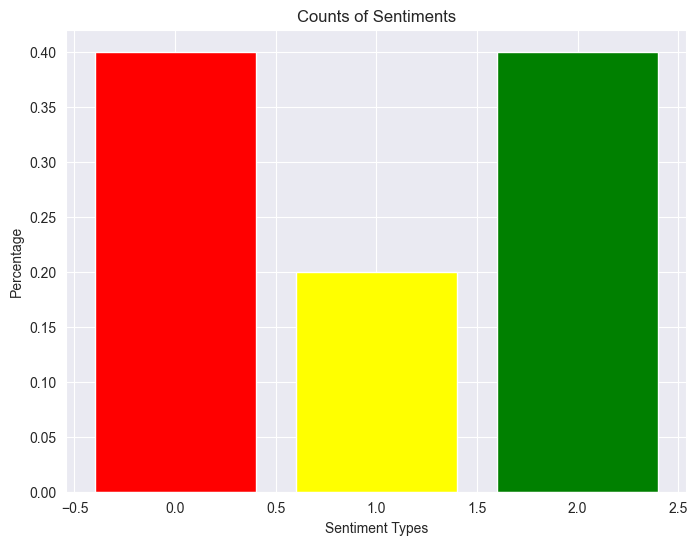

In [37]:
plot_distribution(dataset['sentiment'])

As we expected the middle category is less present. This is important during training

### First dataset selection

The dataset has too many rows, now select only 900k rows with equal sentiment distribution

In [39]:
dataset = sample_balanced(dataset,
                          max_samples_per_class=MAX_SAMPLES_PER_CLASS,
                          groupby_column='sentiment')

Now distributions are all equal

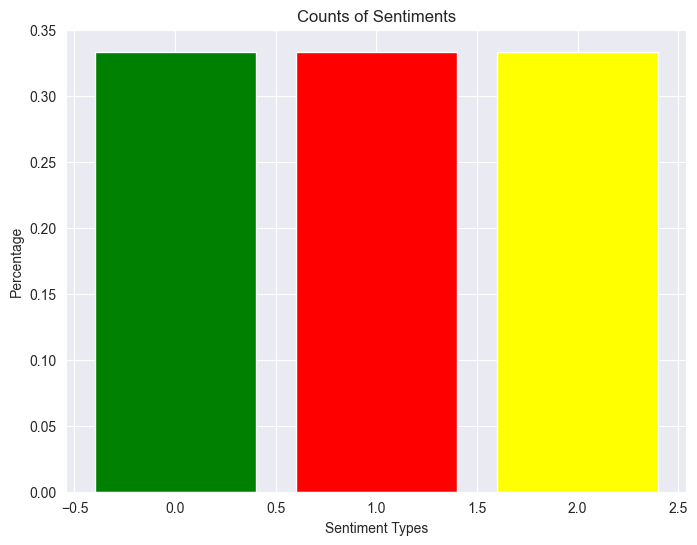

In [40]:
plot_distribution(dataset['sentiment'])

### Language cleaning

Author specifies that there are some reviews not in English. Let's use fasttext, developed by Facebook, to find the languages.

In [41]:
languages_text = compute_languages(dataset['text'])

Now check the distributions of languages

In [42]:
languages_text.value_counts()

text
__label__en    897573
__label__es      1591
__label__ja       454
__label__fr       186
__label__pt        80
__label__de        41
__label__it        31
__label__sr         8
__label__nl         5
__label__tr         4
__label__pl         4
__label__sv         3
__label__id         3
__label__tl         2
__label__da         2
__label__ia         2
__label__ms         2
__label__mk         1
__label__oc         1
__label__cy         1
__label__gl         1
__label__el         1
__label__no         1
__label__kn         1
__label__lt         1
__label__ro         1
Name: count, dtype: int64

There are instances not in English. Remove all not English reviews in title and text

In [43]:
dataset = remove_not_modal_languages(languages_text)(dataset)

file overwrite


### Second dataset selection

Now select 200_000 istances for each class

In [46]:
dataset = sample_balanced(dataset,
                          max_samples_per_class=SAMPLES_PER_CLASS_200K,
                          groupby_column='sentiment')
save_csv(dataset, ONLY_ENGLISH_600K)
dataset

file overwrite


,text,sentiment
0,fulfills its purpose but not for newcomers Wit...,0
1,Where are the subtitles? I'll echo the sentime...,0
2,lacks compassion I found the album to lack com...,0
3,Don't know in what world this is plus size I'm...,0
4,Doesn't follow the book well...at all. The onl...,0
...,...,...
599995,Out of the Ordinary It's nice to see a movie w...,2
599996,A lot of Kids? I got this for my Mom - who has...,2
599997,Attention: Book Clubs Papaya Myths is a must-r...,2
599998,Sixth Sense Finally! A movie worth watching! A...,2


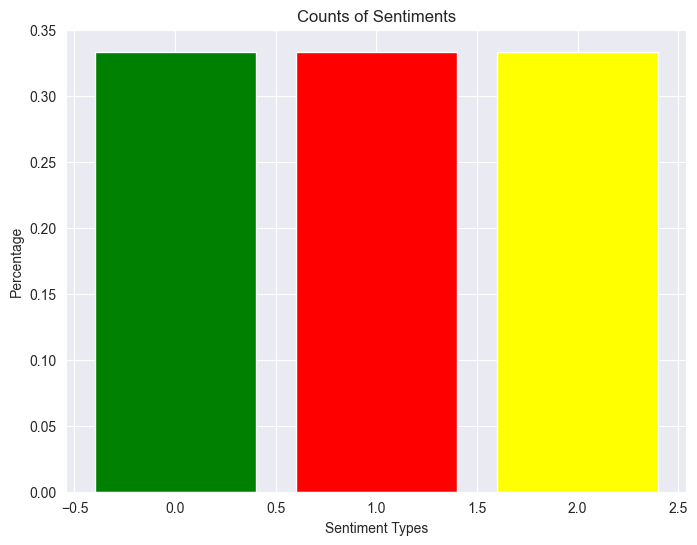

In [47]:
plot_distribution(dataset['sentiment'])

## Text preprocessing TODO rileggi

Now we preprocessed the dataframe to be manipulated and used in deep learning methods and with LSA. The operations that are performed sequentially are:
- text to lower case
- tokenization,
- expansion of contractions,
- word correction,
- stop word removal
- punctuation removal

In [54]:
dataset = load_csv(ONLY_ENGLISH_600K)
dataset['text'] = SentencesPreprocessor().preprocess(dataset['text'])
save_csv(dataset, PREPROCESSED_DATASET_600K)

dataset = load_csv(ONLY_ENGLISH_600K)
dataset['text'] = SentencesPreprocessor(stemming=True).preprocess(dataset['text'])
save_csv(dataset, PREPROCESSED_DATASET_600K_STEMMING)

dataset = load_csv(ONLY_ENGLISH_600K)
dataset['text'] = SentencesPreprocessor(lemming=True).preprocess(dataset['text'])
save_csv(dataset, PREPROCESSED_DATASET_600K_LEMMING)

100%|██████████| 600000/600000 [04:13<00:00, 2362.79it/s]


file overwrite


100%|██████████| 600000/600000 [46:38<00:00, 214.40it/s] 


file overwrite


100%|██████████| 600000/600000 [41:25<00:00, 241.44it/s]


file overwrite


In [16]:
save_csv(dataset, PREPROCESSED_DATASET_600K)
#save_csv(dataset, PREPROCESSED_DATASET_600K_STEMMING)
#save_csv(dataset, PREPROCESSED_DATASET_600K_LEMMING)


file overwrite


In [15]:
reviews = dataset['text'].astype(str)
sentiments = dataset['sentiment']

## Reviews analysis

### Reviews length

In [17]:
print(f"Longest review {reviews.str.split().apply(len).max()}")

Longest review 122


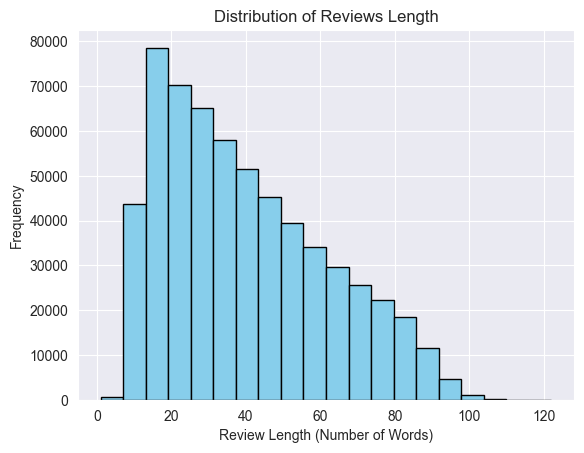

In [18]:
review_lengths = [len(review.split()) for review in reviews]
plt.hist(review_lengths, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Review Length (Number of Words)')
plt.ylabel('Frequency')
plt.title('Distribution of Reviews Length')
plt.show()

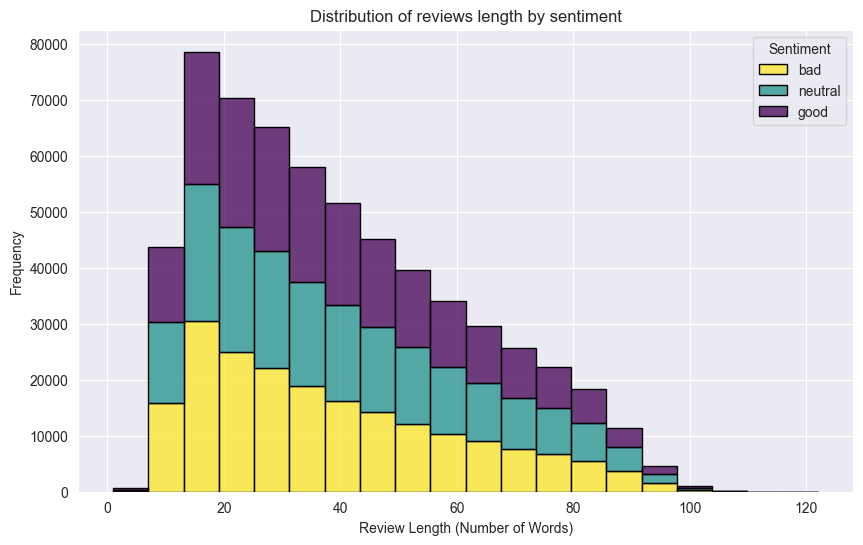

In [30]:
dataset['review_length'] = dataset['text'].astype(str).apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(data=dataset, 
             x='review_length', 
             bins=20, 
             hue='sentiment', 
             multiple='stack', 
             palette='viridis', 
             edgecolor='black')

plt.xlabel('Review Length (Number of Words)')
plt.ylabel('Frequency')
plt.title('Distribution of reviews length by sentiment')
plt.legend(title='Sentiment', labels=ENCODING_TO_CLASS.values())
plt.show()
dataset.drop(columns='review_length', inplace=True)

### Words count

In [16]:
word_counts = Counter()
review_presence = Counter()

In [17]:
for review in reviews:
    words = review.split()
    word_counts.update(words)
    review_presence.update(set(words))

In [19]:
# Get the top 10 most frequent words
words_frequency = word_counts.most_common()
total_words = sum(dict(words_frequency).values())
words_frequency_percentage = {word: frequency / total_words * 100
                              for word, frequency in dict(words_frequency).items()}
words_in_reviews = review_presence.most_common()
words_in_reviews_percentage = {word: frequency / total_words * 100
                               for word, frequency in dict(words_in_reviews).items()}
print(f'Total words in all review: {total_words}')

Total words in all review: 23968029


In [40]:
for word, frequency in words_frequency[:10]:
    print(
        f'{word} {frequency} = {words_frequency_percentage[word]:.2f}% in {dict(words_in_reviews)[word]} = {words_in_reviews_percentage[word]:.2f}% reviews')

book 377921 = 1.58% in 162537 = 0.68% reviews
one 237333 = 0.99% in 172658 = 0.72% reviews
good 223372 = 0.93% in 163971 = 0.69% reviews
like 215604 = 0.90% in 159487 = 0.67% reviews
would 188171 = 0.79% in 147411 = 0.62% reviews
great 169613 = 0.71% in 128586 = 0.54% reviews
read 163216 = 0.68% in 106126 = 0.44% reviews
get 155523 = 0.65% in 123637 = 0.52% reviews
use 152709 = 0.64% in 110501 = 0.46% reviews
time 139944 = 0.59% in 113076 = 0.47% reviews


In [41]:
for word, frequency in words_in_reviews[:10]:
    print(
        f'{word} {dict(words_in_reviews)[word]} = {words_in_reviews_percentage[word]:.2f}% reviews with frequency {frequency} = {words_frequency_percentage[word]:.2f}%')

one 172658 = 0.72% reviews with frequency 172658 = 0.99%
good 163971 = 0.69% reviews with frequency 163971 = 0.93%
book 162537 = 0.68% reviews with frequency 162537 = 1.58%
like 159487 = 0.67% reviews with frequency 159487 = 0.90%
would 147411 = 0.62% reviews with frequency 147411 = 0.79%
great 128586 = 0.54% reviews with frequency 128586 = 0.71%
get 123637 = 0.52% reviews with frequency 123637 = 0.65%
time 113076 = 0.47% reviews with frequency 113076 = 0.59%
use 110501 = 0.46% reviews with frequency 110501 = 0.64%
read 106126 = 0.44% reviews with frequency 106126 = 0.68%


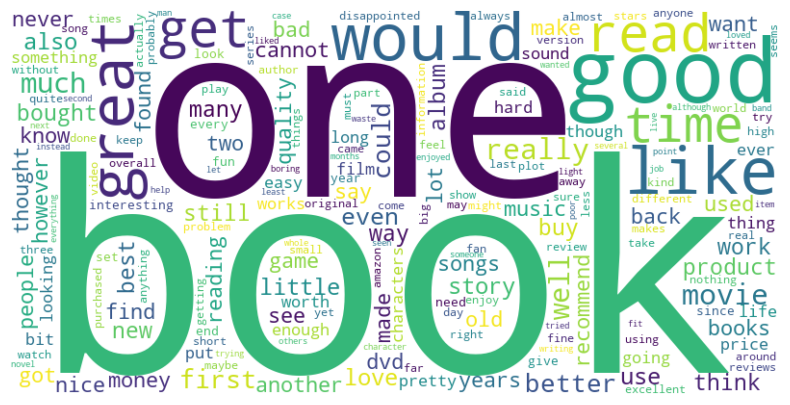

In [28]:
word_cloud(dict(words_frequency))

### Top words

In [239]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(reviews)

In [240]:
word_to_scores = {word: {} for word in tfidf_vectorizer.get_feature_names_out()}
for sentiment in set(sentiments):
    chi2_stat, _ = chi2(tfidf_matrix, np.where(sentiments == sentiment, 1, 0))
    zip_scores = dict(zip(tfidf_vectorizer.get_feature_names_out(), chi2_stat))
    for word, score in zip_scores.items():
        word_to_scores[word][sentiment] = score

In [241]:
word_to_class = {word: max(scores, key=scores.get)
                 for word, scores in word_to_scores.items()}

In [242]:
chi2_stat, _ = chi2(tfidf_matrix, sentiments)
top_scores = dict(zip(tfidf_vectorizer.get_feature_names_out(), chi2_stat))
top_words = [word for word in sorted(top_scores, key=top_scores.get, reverse=True)]

In [243]:
top_words_by_class = {klass: [] for klass in set(sentiments)}
top_n_words = 10
for sorted_word in top_words:
    if all([len(values) >= top_n_words for values in top_words_by_class.values()]):
        break
    if len(top_words_by_class[word_to_class[sorted_word]]) < top_n_words:
        top_words_by_class[word_to_class[sorted_word]].append(sorted_word)
pd.DataFrame(top_words_by_class)

,0,1,2
0,waste,okay,great
1,money,however,excellent
2,worst,bit,love
3,poor,decent,highly
4,boring,ever,awesome
5,terrible,average,wonderful
6,horrible,interesting,disappointed
7,junk,pretty,best
8,awful,overall,perfect
9,good,though,easy


In [244]:
pd.Series([word_to_class[word] for word in top_words[:1_000]]).value_counts()

0    490
2    446
1     64
Name: count, dtype: int64

In [245]:
only_english = load_csv(DATASET_600K)

In [246]:
texts_with_bad = filter_by_text(only_english, 'bad', sentiment=2, limit=3)['text']
print_reviews(texts_with_bad, highlight_texts='bad')

I love this camcorder I love this camcorder. I purchased it online so that I could use it to record my stand up and upload it to you tube and it has not let me down yet. The only thing bad I would say is you must keep a lot of batteries with you if you are going to use it as much as I do because you need AA batteries to power it up. But I honestly think this is the best invention ever well besides the microwave, well there's the car and the stop light and how about the ...well you get the point its a really nice camcorder and it's afforable.
--------------------------------
There's hope for humanity after all.... This is probably one of PKD's easiest reads, so save it for the day when you don't want to confront life's difficulties.... despite all the problems the characters face, there is a happy, almost upbeat, ending (well, as happy as any of his novels gets). The writing/theme/characters/etc reflect as usual his alternative approach, which may not appeal to all readers. But for me, 

### Sentence query

In [247]:
original_reviews = load_csv(DATASET_600K)['text'].values
query = 'this book is horrible'

In [248]:
vectorizer = TfidfVectorizer().fit(reviews)
tf_idf_matrix = vectorizer.transform(reviews)

(600000, 291552)

In [249]:
def find_top_similar_sentences(encoded_query, 
                               encoded_reviews, 
                               original_reviews, 
                               top_n=3):    
    similarities = cosine_similarity(encoded_query, encoded_reviews).flatten()
    top_indices = similarities.argsort()[::-1][:top_n]
    print_reviews(original_reviews[top_indices])

#### Only tf-idf

In [250]:
encoded_query = vectorizer.transform([query])

In [251]:
find_top_similar_sentences(encoded_query, tf_idf_matrix, original_reviews)

Worked great for two weeks, then failed This adapter worked as expected for two weeks, then went kaput during a long road trip (the adapter would make a high-pitched whine during playback). Would not recommend.
--------------------------------
The new Oxford American dictionary I liked it, but was not what I expected. Sorry. I use my american dictionary on my other tablet. Thanks for trying though.
--------------------------------
Too short and lacking to hold my toddler or family. This collection is really too short to be a collection and was missing the two skits that we were out to collect; "But I like you" and "Dance myself to sleep". Not even "Rubber Duckie", which is an Ernie classic, is included. It did have a cute song about friends, the moon song and the association of "W Lovers". Other skits were songless and entertaining for older viewers, all three of them: Egypt, movie,and camping. A portion of the twenty-five minutes or so were filled with joining but not particularily in

#### tf-idf + manual SVD

In [ ]:
svd_components = 100

In [252]:
U, Sigma, VT = randomized_svd(tf_idf_matrix.T, 
                              n_components=svd_components, 
                              random_state=RANDOM_STATE)

In [253]:
print(f'U shape: {U.shape}')
print(f'Sigma shape: {Sigma.shape}')
print(f'VT shape: {VT.shape}')

U shape: (291552, 100)
Sigma shape: (100,)
VT shape: (100, 600000)


In [254]:
q = vectorizer.transform([query]).T
encoded_query = q.T @ U
encoded_reviews = VT.T @ np.diag(Sigma)

In [255]:
find_top_similar_sentences(encoded_query, encoded_reviews, original_reviews)

I would NOT purchase again! NOT even close to what I expected! On television they sound wonderful. But what you get is NOT even the old time Christmas Music.I expected..
--------------------------------
Good CD, but doesn't label edited songs. a previous reviewer mentioned about the editing and how it wasn't labeled for "Rocafeller Skank" by Fatboy Slim..there is another song that's edited -- "American Woman" by Lenny Kravitz...I noticed it right away when the label said "3:49" for length -- the original is about 4 minutes and 20 seconds! (to make it clear, the fade on the song comes in too early at the end) ...usually Now does a good job of labelling the songs if they're an edit, but they didn't do it so they would get a larger audience? Now I don't know if I'm getting the original on any other songs... :( If you want an original copy of all of these songs, buy the single or buy the artist's album.
--------------------------------
Did you people read the same book? Wow, was I disappoi

#### tf-idf + automatic SVD

In [256]:
svd = TruncatedSVD(n_components=svd_components,random_state=RANDOM_STATE)
svd_matrix_docs = svd.fit_transform(tf_idf_matrix)

In [257]:
encoded_query = svd.transform(vectorizer.transform([query]))

In [258]:
find_top_similar_sentences(encoded_query, svd_matrix_docs, original_reviews)

I would NOT purchase again! NOT even close to what I expected! On television they sound wonderful. But what you get is NOT even the old time Christmas Music.I expected..
--------------------------------
Good CD, but doesn't label edited songs. a previous reviewer mentioned about the editing and how it wasn't labeled for "Rocafeller Skank" by Fatboy Slim..there is another song that's edited -- "American Woman" by Lenny Kravitz...I noticed it right away when the label said "3:49" for length -- the original is about 4 minutes and 20 seconds! (to make it clear, the fade on the song comes in too early at the end) ...usually Now does a good job of labelling the songs if they're an edit, but they didn't do it so they would get a larger audience? Now I don't know if I'm getting the original on any other songs... :( If you want an original copy of all of these songs, buy the single or buy the artist's album.
--------------------------------
Did you people read the same book? Wow, was I disappoi

## Train preparation

In [174]:
shuffled_data = dataset.sample(frac=1, random_state=RANDOM_STATE).head(1000)
X = shuffled_data['text'].astype(str)
y = to_categorical(shuffled_data['sentiment'], num_classes=len(set(dataset['sentiment'])))
y_sparse = shuffled_data['sentiment']

(x_train, 
 x_validation, 
 x_test, 
 
 y_train, 
 y_validation, 
 y_test,
 
 y_train_sparse, 
 y_validation_sparse, 
 y_test_sparse) = split_continuously(X, y, y_sparse, partitions=[0.8, 0.1, 0.1])

full_x_train = pd.concat([x_train, x_validation])
full_y_train = np.vstack([y_train, y_validation])
full_y_train_sparse = np.concatenate([y_train_sparse, y_validation_sparse])

train size: 800, test size: 100, validation size: 100


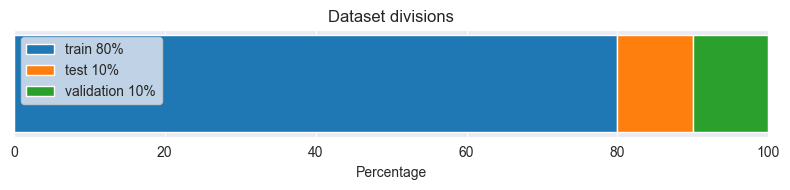

In [175]:
plot_divisions(y_train, y_test, y_validation)

## Non neural models

### Data preparation

In [137]:
# tfidf_vectorizer = TfidfVectorizer(min_df=3, max_df=0.95, ngram_range=(1, 3))
# tfidf_x_train = tfidf_vectorizer.fit_transform(x_train)
# tfidf_x_test = tfidf_vectorizer.transform(x_test)

count_vectorizer = CountVectorizer(binary=True, min_df=3, max_df=0.95, ngram_range=(1, 3))
counted_x_train = count_vectorizer.fit_transform(x_train)
counted_x_test = count_vectorizer.transform(x_test)

### Bernulli

In [139]:
model_name = 'BernulliNB'
bernulli_nb = BernoulliNB()

In [140]:
bernulli_nb = bernulli_nb.fit(counted_x_train, y_train)
save_binary_model(bernulli_nb, model_name)

resources/models/BernulliNB/BernulliNB.bin


In [141]:
train_pred_proba = bernulli_nb.predict_proba(counted_x_train)
test_pred_proba = bernulli_nb.predict_proba(counted_x_test)

In [149]:
save_model_predictions(train_pred_proba, test_pred_proba, model_name, OTHER_MODELS)

       accuracy  precision    recall  f1_score
test   0.659850   0.656677  0.659850  0.656904
train  0.844127   0.844647  0.844127  0.843082

         accuracy  precision    recall  f1_score
bad      0.684091   0.709262  0.684091  0.696449
neutral  0.521571   0.573867  0.521571  0.546471
good     0.774303   0.686937  0.774303  0.728008


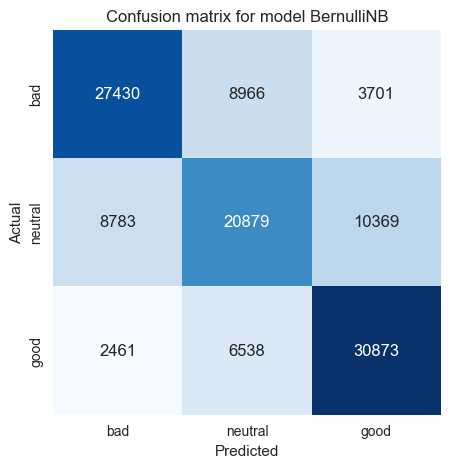

In [148]:
show_model_scores(train_pred_proba, y_train, test_pred_proba, y_test, model_name)

In [ ]:
top_n(x_test, y_test, test_pred_proba)

In [151]:
top_n(x_test, y_test, test_pred_proba, best=False)

boxed disappointed way received item long time friend senior talked item time talked birthday wanted surprise buy disappointed received wanted send back purchase something else receive pictured next box instead came velvet like pouch presentable wanted receive pictured indicating came box stated would boxed items state gave friend anyway felt bad presentation tacky stated beginning review disappointed
class: good predicted with 2.8507143186526365e-17%
good drawbacks overall pretty good buy said one thing take consideration extra money need spend get optimal working status consider much want box condition basic really plays music videos stores files add web browser others generally around could cost pretty penny work exactly want experience customer service bad bought mine amazon button side broke couple months later would turn called gave shipping information sent repair place word weeks one day shows doorstep good new charge fee
class: good predicted with 1.1251665092947024e-19%
yes m

### CatBoost

In [150]:
top_n(x_test, y_test, test_pred_proba)

promising yet ultimately falls short mixed feelings book kind reminds kids school knew absolutely brilliant capable straight yet managed average shanghvi prose lush analogies satisfying yet almost drowns script book moves characters certainly interesting yet lose momentum towards end novel plot loses zest becoming bogged philosophical reveries exhaust reader ambiguity could argue point however much ambiguity reader take look forward writer produce future considering first novel would say good job overall
class: neutral predicted with 100.0%
start elsewhere sadly cities plain disappoints comparison first two volumes border trilogy possible expected much think merely less successful book story places billy parham john grady cole protagonists previous books together ranch new mexico setting romantic feel novels good action throughout story flow well less believable previous books edition relies many flashbacks well written add much series think important read cities plain read enjoyed res

In [ ]:
param_space = {
    'learning_rate': (0.01, 0.3),
    'depth': (4, 12),
    'iterations': (100, 2000),
    'l2_leaf_reg': (1, 10),
    'leaf_estimation_method': ['Newton', 'Gradient']
}

fixed_params = {
    'device_type': 'GPU',
    'loss_function': 'MultiClass',
    'verbose': True
}


In [ ]:
best_model, best_params = bayes_grid_search(CatBoostClassifier,
                                            param_space,
                                            tfidf_x_train,
                                            y_train,
                                            fixed_params=fixed_params,
                                            init_points=0,
                                            cv=2,
                                            n_iter=1)
save_binary_model(best_model, CAT_BOOST)

|   iter    |  target   |   depth   | iterat... | l2_lea... | leaf_e... | learni... |
-------------------------------------------------------------------------------------
0:	learn: 1.0736446	total: 4.27s	remaining: 0us
0:	learn: 1.0719150	total: 5.5s	remaining: 0us
| 1         | 0.4557    | 5.532     | 1.0       | 4.94      | 0.7854    | 0.2362    |
0:	learn: 1.0676005	total: 2m 46s	remaining: 0us


In [ ]:
grid_search_cv(CatBoostClassifier(loss_function='MultiClass', verbose=True),
               param_space,
               tfidf_x_train,
               y_train,
               cv=3,
               **fit_params)

NameError: name 'fit_params' is not defined

In [ ]:
# Make predictions on the TF-IDF transformed test data
y_pred = best_model.predict(X_test_tfidf)

# Evaluate the model
classification_rep = classification_report(y_test, y_pred)
print(classification_rep)

              precision    recall  f1-score   support

           0       0.51      0.75      0.60     39652
           1       0.29      0.28      0.29     20207
           2       0.67      0.37      0.47     40141

    accuracy                           0.50    100000
   macro avg       0.49      0.46      0.45    100000
weighted avg       0.53      0.50      0.49    100000


## Deep neural networks

### Commons

In [176]:
max_sequence_length = max([len(sentence) for sentence in x_train.str.split()])

In [177]:
vectorize_layer = TextVectorization(standardize=None,
                                    max_tokens=MAX_TOKENS,
                                    ngrams=N_GRAMS,
                                    output_sequence_length=max_sequence_length)
vectorize_layer.adapt(x_train)
models = {}

In [182]:
def callbacks(model_name: str):
    return [
        EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True),
        ModelCheckpoint(f'{KERAS_MODELS_FOLDER}/{model_name}/{model_name}',
                        monitor='val_accuracy',
                        save_best_only=True),
        ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3)
    ]

### Models structure definition

#### 1D CNN

In [203]:
model_name = 'CNN'
model = build_nn_model([
    layers.Input(shape=(1,), dtype='string'),
    vectorize_layer,
    layers.Embedding(MAX_TOKENS, 64),

    layers.Conv1D(64, 5),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.GlobalMaxPooling1D(),
], model_name)
models[model_name] = model
model.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, 100)               0         
 Vectorization)                                                  
                                                                 
 embedding_6 (Embedding)     (None, 100, 64)           640000    
                                                                 
 conv1d_2 (Conv1D)           (None, 96, 64)            20544     
                                                                 
 batch_normalization_2 (Bat  (None, 96, 64)            256       
 chNormalization)                                                
                                                                 
 activation_2 (Activation)   (None, 96, 64)            0         
                                                                 
 global_max_pooling1d_2 (Gl  (None, 64)                0       

#### GRU

In [205]:
model_name = 'GRU'

model = build_nn_model([
    layers.Input(shape=(1,), dtype='string'),
    vectorize_layer,
    layers.Embedding(MAX_TOKENS, 128, mask_zero=True),
    layers.GRU(128)
], model_name)
models[model_name] = model
model.summary()

Model: "GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, 100)               0         
 Vectorization)                                                  
                                                                 
 embedding_8 (Embedding)     (None, 100, 128)          1280000   
                                                                 
 gru_5 (GRU)                 (None, 128)               99072     
                                                                 
 dense_8 (Dense)             (None, 3)                 387       
                                                                 
Total params: 1379459 (5.26 MB)
Trainable params: 1379459 (5.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Bidirectinal GRU

In [207]:
model_name = 'Bidirectional_GRU'

model = build_nn_model([
    layers.Input(shape=(1,), dtype='string'),
    vectorize_layer,
    layers.Embedding(MAX_TOKENS, 128, mask_zero=True),
    layers.Bidirectional(layers.GRU(128))
], model_name)
models[model_name] = model
model.summary()

Model: "Bidirectional_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, 100)               0         
 Vectorization)                                                  
                                                                 
 embedding_10 (Embedding)    (None, 100, 128)          1280000   
                                                                 
 bidirectional_4 (Bidirecti  (None, 256)               198144    
 onal)                                                           
                                                                 
 dense_10 (Dense)            (None, 3)                 771       
                                                                 
Total params: 1478915 (5.64 MB)
Trainable params: 1478915 (5.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### LSTM

In [209]:
model_name = 'LSTM'

model = build_nn_model([
    layers.Input(shape=(1,), dtype='string'),
    vectorize_layer,
    layers.Embedding(MAX_TOKENS, 128, mask_zero=True),
    layers.LSTM(128)
], model_name)
models[model_name] = model
model.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, 100)               0         
 Vectorization)                                                  
                                                                 
 embedding_12 (Embedding)    (None, 100, 128)          1280000   
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense_12 (Dense)            (None, 3)                 387       
                                                                 
Total params: 1411971 (5.39 MB)
Trainable params: 1411971 (5.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Model training

Epoch 1/100
7/7 [==============================] - ETA: 0s - loss: 1.0963 - accuracy: 0.3663INFO:tensorflow:Assets written to: resources/keras_models/test_gru\test_gru\assets


INFO:tensorflow:Assets written to: resources/keras_models/test_gru\test_gru\assets


7/7 [==============================] - 7s 1s/step - loss: 1.0963 - accuracy: 0.3663 - val_loss: 1.1012 - val_accuracy: 0.3300 - lr: 2.5000e-04
Epoch 2/100
7/7 [==============================] - 1s 187ms/step - loss: 1.0964 - accuracy: 0.3663 - val_loss: 1.1012 - val_accuracy: 0.3300 - lr: 2.5000e-04
Epoch 3/100
7/7 [==============================] - 1s 185ms/step - loss: 1.0965 - accuracy: 0.3663 - val_loss: 1.1009 - val_accuracy: 0.3300 - lr: 2.5000e-04
Epoch 4/100
7/7 [==============================] - 1s 188ms/step - loss: 1.0963 - accuracy: 0.3663 - val_loss: 1.1003 - val_accuracy: 0.3300 - lr: 2.5000e-04
Epoch 5/100
7/7 [==============================] - 1s 189ms/step - loss: 1.0965 - accuracy: 0.3663 - val_loss: 1.1002 - val_accuracy: 0.3300 - lr: 1.2500e-04
Epoch 6/100
7/7 [==============================] - 1s 187ms/step - loss: 1.0964 - accuracy: 0.3663 - val_loss: 1.1005 - val_accuracy: 0.3300 - lr: 1.2500e-04
Epoch 7/100
7/7 [==============================] - 1s 184ms/step - 

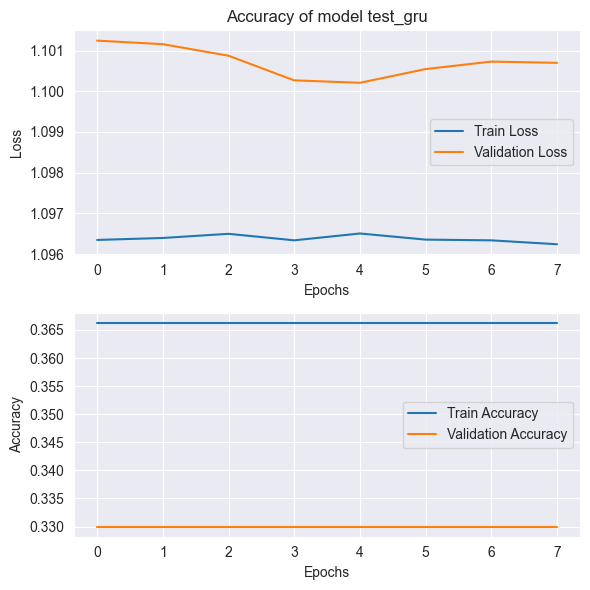

       accuracy  precision    recall  f1_score
test   0.360000   0.129600  0.360000  0.190588
train  0.362222   0.446102  0.362222  0.193981

         accuracy  precision  recall  f1_score
bad           0.0       0.00     0.0  0.000000
neutral       1.0       0.36     1.0  0.529412
good          0.0       0.00     0.0  0.000000


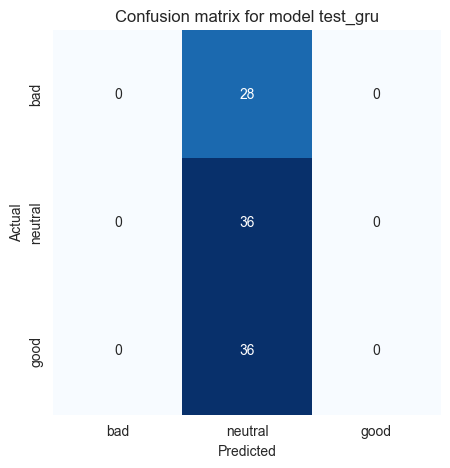

Best predictions
backward compatible like father trying make child happy buy first childrens titles maybe years second console backward compatible games check microsoft site confirm levels deep box site however xbox manual tell third toys sell xbox games claim work new box simply rare case work must first download install software patch make sense finally xbox decent dvd player great graphics hdtv hookups supplies component cables huge fan microsoft product waste money also waste child time
class: bad predicted with 31.84952139854431%
right color two pictures natural wood stool different step stools one laminate wood one natural wood thicker pieces material inset screws way know going get one received basically yellow laminated plywood type wanting step stool made solid pieces wood stained classic oak color product pictured correctly described text anyone goes kidkraft com web site clicks buy online first item search list comes amazon warned item pictured kidkraft com amazon selling st

In [199]:
for model_name, model in models.items():
    history = model.fit(x_train,
                        y_train,
                        batch_size=BATCH_SIZE,
                        epochs=DEFAULT_EPOCHS,
                        validation_data=(x_validation, y_validation),
                        callbacks=callbacks(model_name))
    plot_history(history, model_name)
    train_predictions = model.predict(full_x_train, verbose=False)
    test_predictions = model.predict(x_test, verbose=False)
    save_model_predictions(train_predictions, 
                           test_predictions, 
                           model_name, 
                           KERAS_MODELS_FOLDER)
    show_model_scores(train_predictions, full_y_train_sparse,
                      test_predictions, y_test_sparse,
                      model_name)
    print('Best predictions')
    top_n(x_test, y_test_sparse, test_predictions)
    print('Worst predictions')
    top_n(x_test, y_test_sparse, test_predictions, best=False)

### Models Results

In [219]:
models_scores = get_keras_model_scores('GRU_*', y_test_sparse)
models_scores_df = pd.DataFrame.from_dict(models_scores, orient='index') \
    .sort_values(by='accuracy', ascending=False)
models_scores_df

ValueError: Found input variables with inconsistent numbers of samples: [100, 60000]

In [120]:
best_models_by_score = {}
for metric in ['accuracy', 'precision', 'recall', 'f1_score']:
    best_model_name = max(models_scores, key=lambda model: models_scores[model][metric])
    best_models_by_score[metric] = best_model_name
    print(f'{best_model_name} {metric}: {models_scores[best_model_name][metric]}')

GRU_10000_2_gram accuracy: 0.69955
GRU_5000_3_gram_stemming precision: 0.6978517457050103
GRU_10000_2_gram recall: 0.69955
GRU_10000_2_gram f1_score: 0.6972796492158249


       accuracy  precision    recall  f1_score
test   0.699550   0.696294  0.699550   0.69728
train  0.730117   0.727233  0.730117   0.72797

         accuracy  precision    recall  f1_score
bad      0.737859   0.740318  0.737859  0.739087
neutral  0.563039   0.608173  0.563039  0.584736
good     0.796857   0.740101  0.796857  0.767431


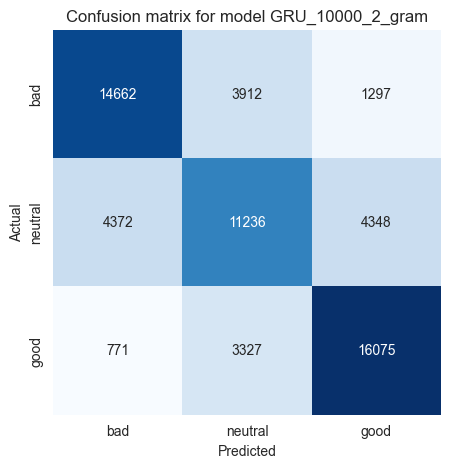

In [121]:
model_name = best_models_by_score['accuracy']
train_pred, test_pred = load_model_predictions(model_name, KERAS_MODELS_FOLDER)
show_model_scores(train_pred, full_y_train_sparse, test_pred, y_test_sparse, model_name)

In [ ]:
top_n(x_test, y_test_sparse, test_pred)

In [ ]:
top_n(x_test, y_test_sparse, test_pred)

In [122]:
models_comparisons = compare_models_with_confidence(models_scores, confidence_level=0.95)

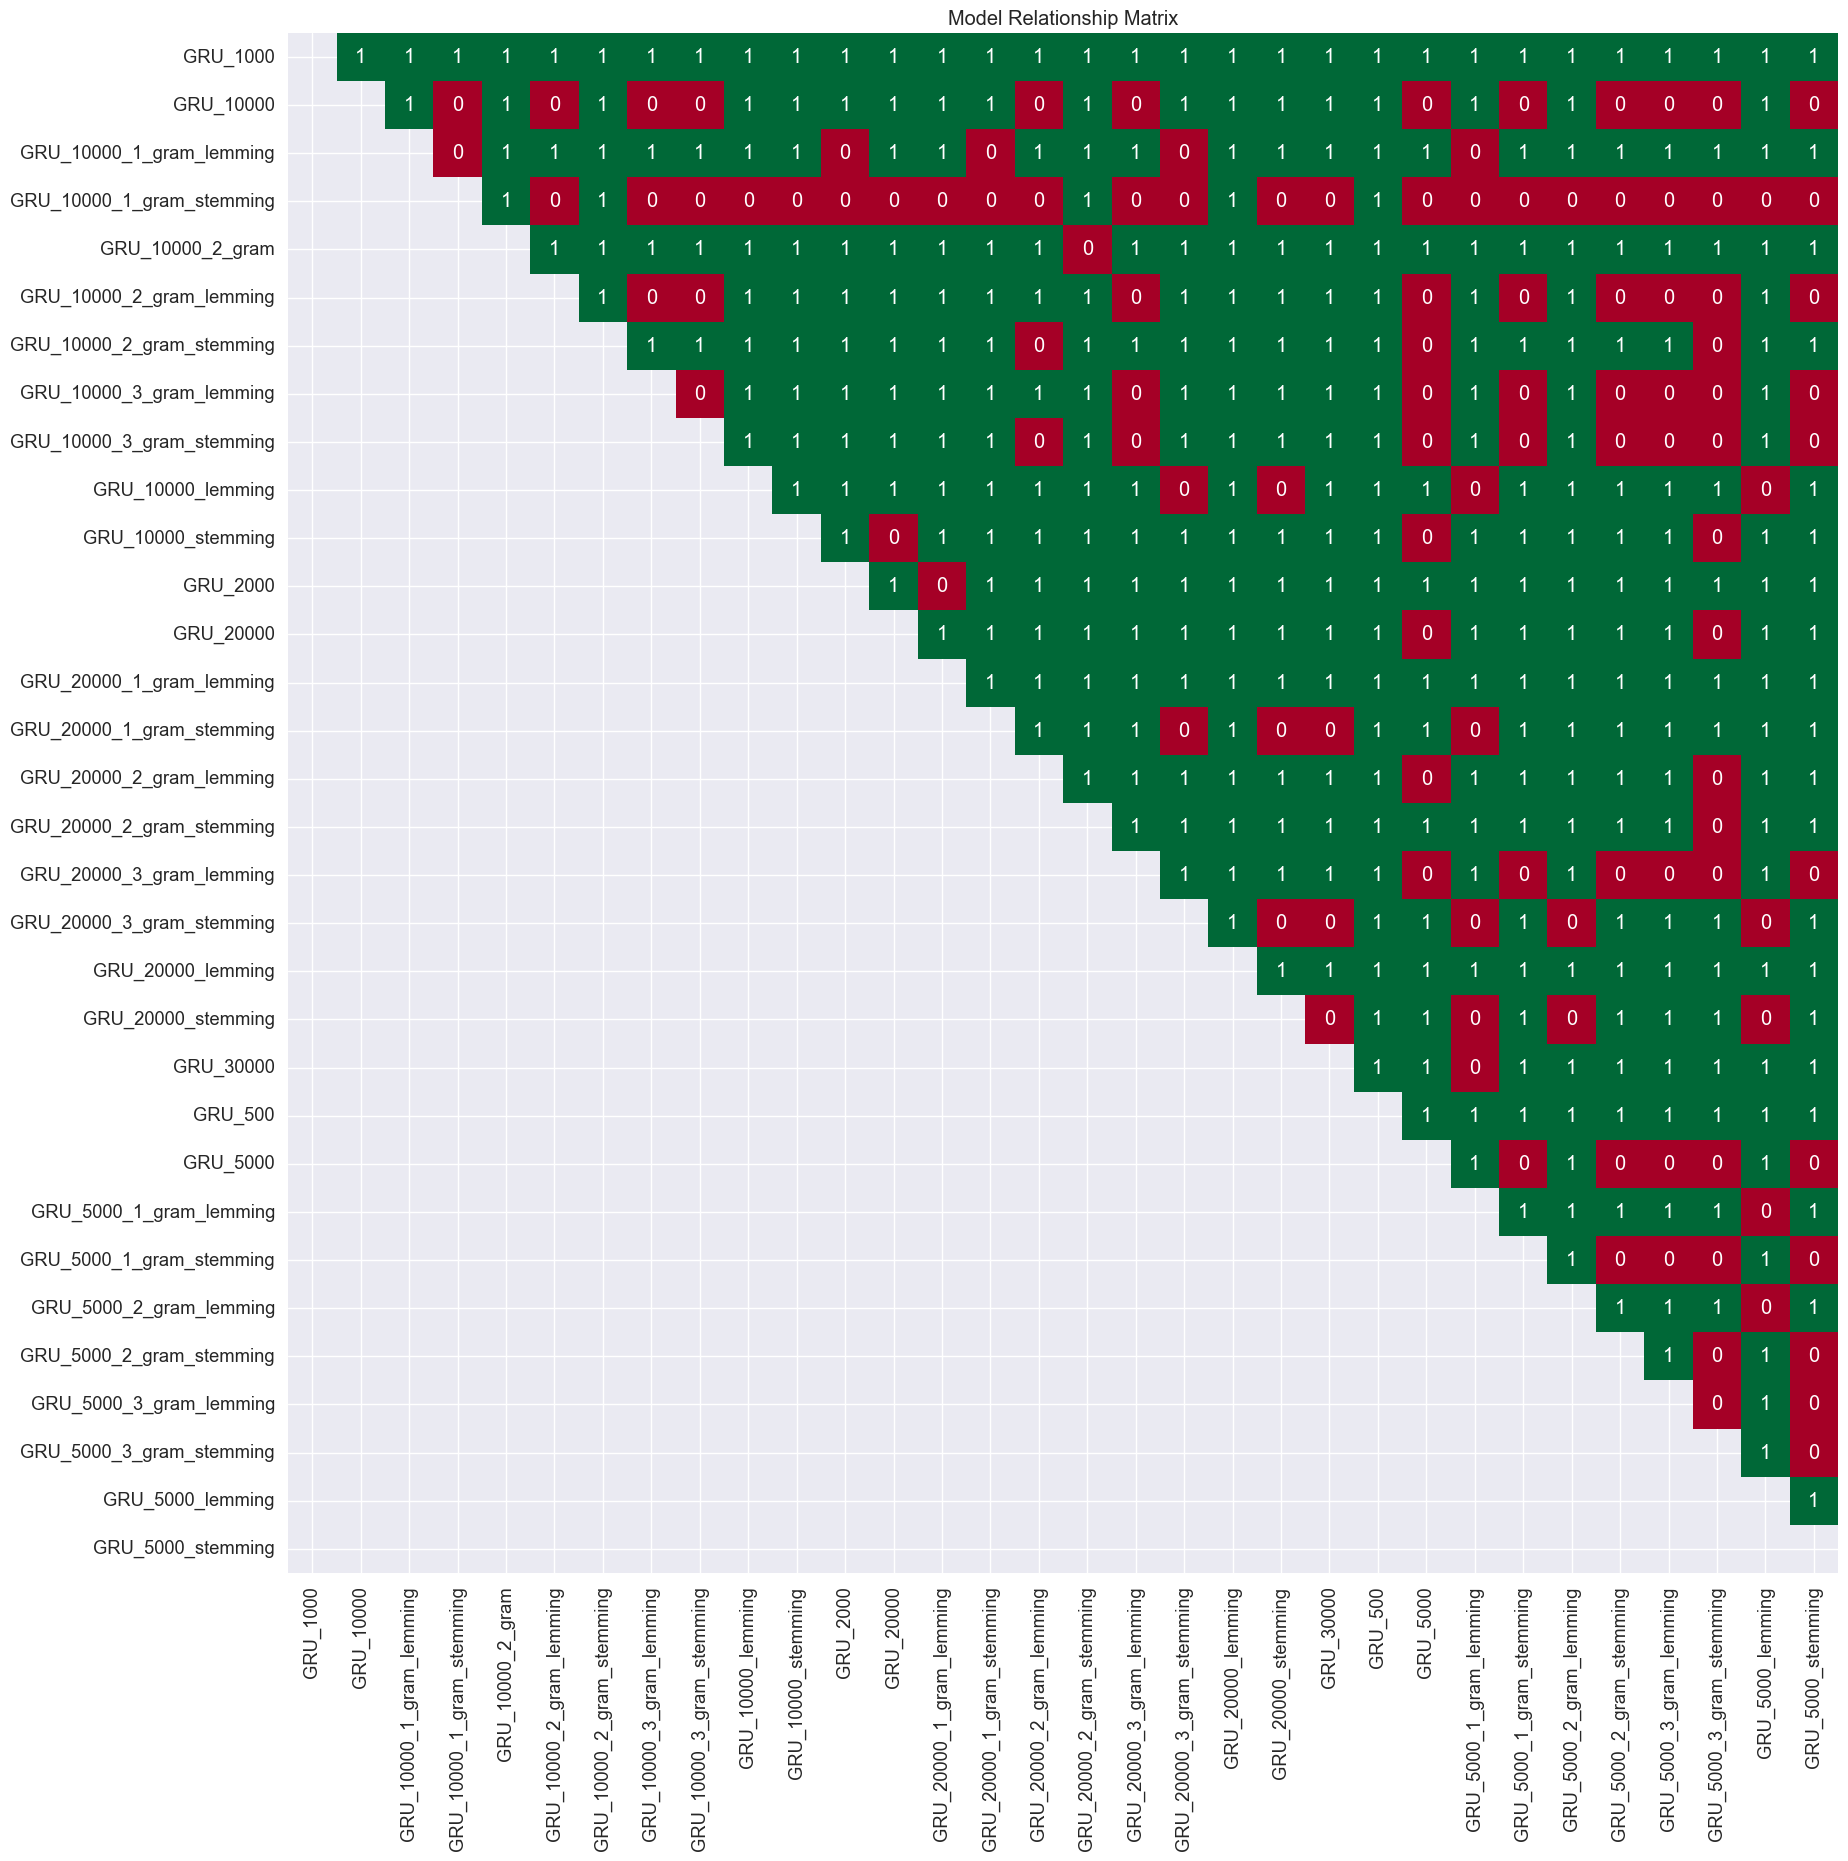

In [128]:
show_comparisons(models_comparisons)

## Pre-trained models

### Universal sentence encoder

In [268]:
model_name = f'USE'

model = build_nn_model([
    hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                   trainable=True,
                   dtype=tf.string,
                   input_shape=[]),
    layers.Reshape((1, -1)),
    layers.GRU(128),
], model_name)

model.summary()

Model: "USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 512)               256797824 
                                                                 
 reshape_1 (Reshape)         (None, 1, 512)            0         
                                                                 
 gru_14 (GRU)                (None, 128)               246528    
                                                                 
 dense_19 (Dense)            (None, 3)                 387       
                                                                 
Total params: 257044739 (980.55 MB)
Trainable params: 257044739 (980.55 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [269]:
history = model.fit(x_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=DEFAULT_EPOCHS,
                    validation_data=(x_validation, y_validation),
                    callbacks=callbacks(model_name))

Epoch 1/100
7/7 [==============================] - ETA: 0s - loss: 1.0920 - accuracy: 0.3562INFO:tensorflow:Assets written to: resources/keras_models/USE\USE\assets


INFO:tensorflow:Assets written to: resources/keras_models/USE\USE\assets


7/7 [==============================] - 77s 7s/step - loss: 1.0920 - accuracy: 0.3562 - val_loss: 1.0791 - val_accuracy: 0.3800 - lr: 0.0010
Epoch 2/100
1/7 [===>..........................] - ETA: 12s - loss: 1.0623 - accuracy: 0.5312

KeyboardInterrupt: 

In [ ]:
plot_history(history, model_name)

In [ ]:
# train_predictions = model.predict(full_x_train)
# test_predictions = model.predict(x_test)
# save_model_predictions(train_predictions, 
#                        test_predictions, 
#                        model_name, 
#                        KERAS_MODELS_FOLDER)
train_predictions, test_predictions = load_model_predictions(model_name,
                                                             KERAS_MODELS_FOLDER)

In [ ]:
show_model_scores(train_predictions, full_y_train_sparse,
                  test_predictions, y_test_sparse,
                  model_name)

In [ ]:
top_n(x_test, y_test_sparse, test_predictions)

In [ ]:
top_n(x_test, y_test_sparse, test_predictions, best=False)

### Using GloVe embeddings

In [152]:
glove_embeddings = load_glove_embedding(GLOVE_EMBEDDING)

In [178]:
embedding_matrix = np.zeros((MAX_TOKENS + 1, GLOVE_EMBEDDING_SIZE))
for i, word in enumerate(vectorize_layer.get_vocabulary()):
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [259]:
model_name = f'GloVe'

model = build_nn_model([
    layers.Input(shape=(1,), dtype='string'),
    vectorize_layer,
    layers.Embedding(MAX_TOKENS + 1,
                     GLOVE_EMBEDDING_SIZE,
                     weights=[embedding_matrix],
                     input_length=max_sequence_length,
                     mask_zero=True,
                     trainable=False),
    layers.Bidirectional(layers.GRU(128))
], model_name)
model.summary()

Model: "GloVe"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, 100)               0         
 Vectorization)                                                  
                                                                 
 embedding_15 (Embedding)    (None, 100, 300)          3000300   
                                                                 
 bidirectional_7 (Bidirecti  (None, 256)               330240    
 onal)                                                           
                                                                 
 dense_15 (Dense)            (None, 3)                 771       
                                                                 
Total params: 3331311 (12.71 MB)
Trainable params: 331011 (1.26 MB)
Non-trainable params: 3000300 (11.45 MB)
_________________________________________________________________


In [260]:
history = model.fit(x_train,
                    y_train, 
                    validation_data=(x_validation, y_validation), 
                    epochs=1,#DEFAULT_EPOCHS, 
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks(model_name))

7/7 [==============================] - ETA: 0s - loss: 1.0967 - accuracy: 0.3900INFO:tensorflow:Assets written to: resources/keras_models/GloVe\GloVe\assets


INFO:tensorflow:Assets written to: resources/keras_models/GloVe\GloVe\assets


7/7 [==============================] - 38s 4s/step - loss: 1.0967 - accuracy: 0.3900 - val_loss: 1.0920 - val_accuracy: 0.4400 - lr: 0.0010


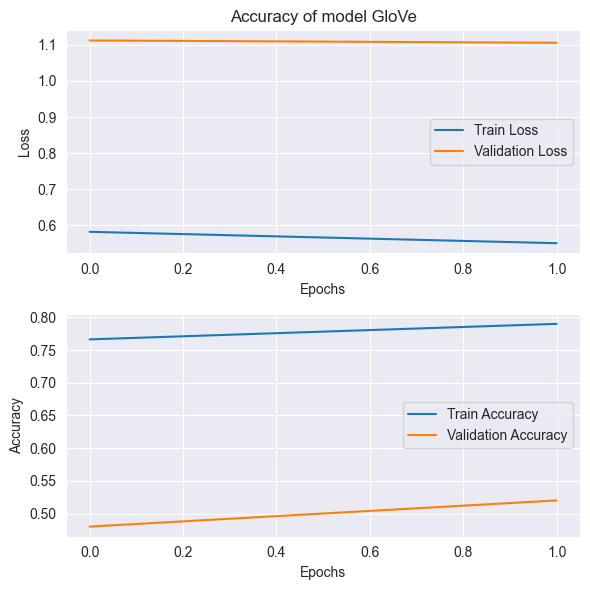

In [215]:
plot_history(history, model_name)

In [217]:
# train_predictions = model.predict(full_x_train)
# test_predictions = model.predict(x_test)
# save_model_predictions(train_predictions, 
#                        test_predictions, 
#                        model_name, 
#                        KERAS_MODELS_FOLDER)
train_predictions, test_predictions = load_model_predictions(model_name,
                                                             KERAS_MODELS_FOLDER)

       accuracy  precision    recall  f1_score
test   0.550000   0.559257  0.550000  0.550015
train  0.761111   0.763721  0.761111  0.758653

         accuracy  precision    recall  f1_score
bad      0.607143   0.472222  0.607143  0.531250
neutral  0.472222   0.586207  0.472222  0.523077
good     0.583333   0.600000  0.583333  0.591549


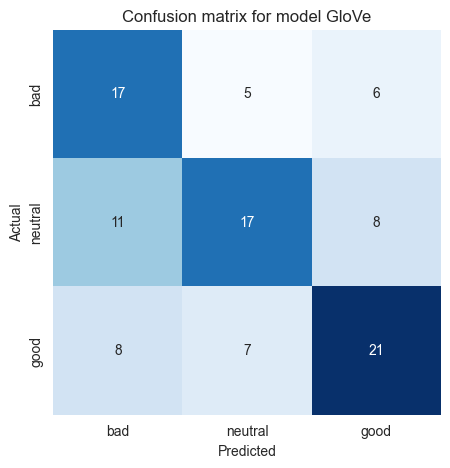

In [218]:
show_model_scores(train_predictions, full_y_train_sparse,
                  test_predictions, y_test_sparse,
                  model_name)

In [234]:
top_n(x_test, y_test_sparse, test_predictions)

horrible absolutely agree reviews could print return would let uncheck boxes checked back file status filing information gone tried chatting customer representatives online gave robotic answers nothing questions absolutely horrible product use unless want waste time frustrated
class: bad predicted with 96.52%
walk toy majority one waste money idea good actual toy worst ever purchased lights tiny little pointy lightbulbs change color moved diagonal never move right way impossible get whole screen start black stylus comes useless little lightbulbs bounce instead moving one direction acheieve one color minute running fingers across lights fingers actually get sore one christmas present going right back store getting exchanged large magna doodle
class: bad predicted with 96.32%
fantastic youg singer sure renee even teenager made would pretty good singer age fantastic considering lower half teenage skeptical ability decent georgia mind pulled amazing job strong throughout makes
class: good 

In [235]:
top_n(x_test, y_test_sparse, test_predictions, best=False)

tommy tommy concept album good album ruined silly filler tommy hear doctor simply get story across think would possible make real songs fill ideas however enough fantastic songs record make many songs could singles easily enough although pinball wizard going take make sense context album actual songs album truly bad like melody read lyrics vise versa think album least places best artists time pete townsend best songwriter
class: good predicted with 2.1%
hemingway enjoyed paul newman film plot could better portrayal secondary characters needless orsen welles enjoyable watch joanne woodward father angela lansbury cute role welle girlfriend best paul newman movie always gorgeous look
class: bad predicted with 2.15%
kashmir spinach good tasty bite items really great kashmir spinach third tasty bite offering tried look taste quite unappealing would consider buying high hopes based much loved tasty bite items tried luck one encourage try agra peas jaipur vegetables instead two tasty bite ite

### Transformers

In [18]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained('bert-base-cased', cache_dir=MODELS_DATA)

In [19]:
def tokenize_texts(texts: np.Series) -> np.array:
    return dict(tokenizer(texts, return_tensors="np", padding=True))

In [33]:
tokenized_x_train = tokenize_texts(x_train[:10_000].tolist())
tokenized_x_validation = tokenize_texts(x_validation[:10_000].tolist())
tokenized_x_test = tokenize_texts(x_test[:10_000].tolist())

In [ ]:
tokenized_x_train = tokenize_texts(x_train.tolist())
tokenized_x_validation = tokenize_texts(x_validation.tolist())
tokenized_x_test = tokenize_texts(x_test.tolist())

In [21]:
print(f'Tokenized_x_train dict keys: {tokenized_x_train.keys()}')
print(f'Tokenized_x_train vectors shape: {tokenized_x_train["input_ids"].shape}')

Tokenized_x_train dict keys: dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
Tokenized_x_train vectors shape: (50000, 187)


In [ ]:
model.fit(tokenized_x_train,  
          y_train[:10_000], 
          validation_data=(tokenized_x_validation, y_validation[:50_000]),
          batch_size=BATCH_SIZE,
          epochs=DEFAULT_EPOCHS)
          # callbacks=callbacks(model_name))

Epoch 1/100
 1/79 [..............................] - ETA: 3:44:03 - loss: 3.0580

In [6]:
!pip list

Package                      Version
---------------------------- ------------
absl-py                      1.4.0
annotated-types              0.6.0
anyascii                     0.3.2
anyio                        4.0.0
argon2-cffi                  23.1.0
argon2-cffi-bindings         21.2.0
arrow                        1.2.3
asttokens                    2.4.0
astunparse                   1.6.3
async-lru                    2.0.4
attrs                        23.1.0
Babel                        2.12.1
backcall                     0.2.0
bayesian-optimization        1.4.3
beautifulsoup4               4.12.2
bleach                       6.0.0
blis                         0.7.11
cachetools                   5.3.1
catalogue                    2.0.10
catboost                     1.2.2
certifi                      2023.7.22
cffi                         1.15.1
charset-normalizer           3.2.0
click                        8.1.7
cloudpathlib                 0.16.0
colorama                     0.4.

In [4]:
from transformers import pipeline

In [5]:
pipe = pipeline('sentiment-analysis', 
                model='finiteautomata/bertweet-base-sentiment-analysis',
                tokenizer='finiteautomata/bertweet-base-sentiment-analysis',
                cache_dir=MODELS_DATA)

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


In [22]:
from keras.optimizers import AdamW

model = TFAutoModelForSequenceClassification.from_pretrained("bert-base-cased", 
                                                             cache_dir=MODELS_DATA,
                                                             num_labels=len(set(dataset['sentiment'])))
model.compile(optimizer=AdamW(3e-5), loss='categorical_crossentropy')

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [61]:
predictions = [pipe(sentence) for sentence in tqdm(dataset['text'].tolist())]




  0%|          | 0/600000 [00:00<?, ?it/s]


  0%|          | 1/600000 [00:00<43:10:34,  3.86it/s]


  0%|          | 2/600000 [00:01<104:51:23,  1.59it/s]


  0%|          | 3/600000 [00:01<87:46:04,  1.90it/s] 


  0%|          | 4/600000 [00:03<168:29:14,  1.01s/it]


  0%|          | 5/600000 [00:03<128:53:22,  1.29it/s]


  0%|          | 6/600000 [00:03<97:59:02,  1.70it/s] 
KeyboardInterrupt



In [53]:
pipe(dataset['text'].tolist()[:10])

InvalidArgumentError: Exception encountered when calling layer 'embeddings' (type TFRobertaEmbeddings).

{{function_node __wrapped__ResourceGather_device_/job:localhost/replica:0/task:0/device:CPU:0}} indices[0,128] = 130 is not in [0, 130) [Op:ResourceGather] name: 

Call arguments received by layer 'embeddings' (type TFRobertaEmbeddings):
  • input_ids=tf.Tensor(shape=(1, 150), dtype=int32)
  • position_ids=None
  • token_type_ids=tf.Tensor(shape=(1, 150), dtype=int32)
  • inputs_embeds=None
  • past_key_values_length=0
  • training=False

In [ ]:
mapping = {
    'NEG': 0,
    'NEU': 1,
    'POS': 2
}

In [ ]:
accuracy_score(dataset['sentiment'], 
               [mapping[sentiment['label']]for sentiment in predictions])

### Transformers 2

In [34]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, EarlyStoppingCallback, TrainingArguments, Trainer


In [49]:
# Utilised functions
class Dataset(torch.utils.data.Dataset):
      
    def __init__(self, inputs, labels):          
        self.inputs = inputs['input_ids']
        self.attentions = inputs['attention_mask']      
        self.labels = labels

    def __len__(self):
        return len(self.inputs)
     
    def __getitem__(self, idx):
        input = self.inputs[idx]
        attention = self.attentions[idx]

        if self.labels is None:
            sample = {'input_ids': input, 'attention_mask': attention}
        
        else:
            label = self.labels[idx]
            sample = {'input_ids': input, 'attention_mask': attention, 'labels': label}
        
        return sample

def compute_scores(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    return {'accuracy': accuracy}

In [55]:
# Encode the texts using a pretrained tokenizer
train_features = tokenizer(list(x_train), truncation=True, padding=True, return_tensors='pt')
full_train_features = tokenizer(list(full_x_train), truncation=True, padding=True, return_tensors='pt')
validation_features = tokenizer(list(x_validation), truncation=True, padding=True, return_tensors='pt')
test_features = tokenizer(list(x_test), truncation=True, padding=True, return_tensors='pt')

# Create the training, validation and test datasets
train_dataset = Dataset(train_features, list(y_train_sparse))
full_train_dataset = Dataset(full_train_features, list(full_y_train_sparse))
validation_dataset = Dataset(validation_features, list(y_validation_sparse))
test_dataset = Dataset(test_features, None)

In [56]:
# Define the trainer
args = TrainingArguments(
    output_dir='output',
    evaluation_strategy ='steps',
    eval_steps=100,
    save_total_limit=1,
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    num_train_epochs=1,
    metric_for_best_model='accuracy',
    load_best_model_at_end=True)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,   
    compute_metrics=compute_scores,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)])

# Train the pre-trained model
trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=3, training_loss=0.7885022163391113, metrics={'train_runtime': 73.8263, 'train_samples_per_second': 1.084, 'train_steps_per_second': 0.041, 'total_flos': 4275593038080.0, 'train_loss': 0.7885022163391113, 'epoch': 1.0})

In [57]:
trainer.predict(test_dataset).predictions

array([[ 3.2381039, -0.8539007, -2.6161528],
       [ 0.4760466,  0.0670548, -1.0081139],
       [ 1.6026341, -0.4066973, -1.6720734],
       [ 3.253188 , -1.0702482, -2.3986714],
       [ 3.22157  , -1.0748379, -2.3955696],
       [ 3.2627077, -0.8831085, -2.568682 ],
       [ 3.1657186, -0.6079549, -2.8638208],
       [ 3.227818 , -1.1275244, -2.356107 ],
       [ 3.2475052, -1.1340758, -2.3272426],
       [ 3.0321026, -0.7841232, -2.512002 ]], dtype=float32)

## Failures

### Word embedding

In [30]:
model = Word2Vec(reviews.str.split(),
                 vector_size=128,
                 window=5,
                 min_count=3,
                 epochs=10)

KeyboardInterrupt: 

In [ ]:
for word, similarity in model.wv.most_similar(['good'], topn=5):
    print(f'{word}: {round(similarity * 100)}%')

### VADER

In [161]:
X = dataset['text'].astype(str)
y = dataset['sentiment']
model_name = 'VADER'
analyzer = SentimentIntensityAnalyzer()

def from_score_to_sentiment(score):
    return [score['neg'], score['neu'], score['pos']]


# vader_proba = np.array([from_score_to_sentiment(analyzer.polarity_scores(review))
#                         for review in tqdm(X.values, position=0, leave=True)])
# save_model_prediction(vader_proba, model_name, OTHER_MODELS)
vader_proba = load_model_prediction(model_name, OTHER_MODELS)

      accuracy  precision    recall  f1_score
test  0.371857   0.581589  0.371857  0.267842

         accuracy  precision    recall  f1_score
bad      0.017665   0.755399  0.017665  0.034523
neutral  0.927865   0.341881  0.927865  0.499658
good     0.170040   0.647488  0.170040  0.269346


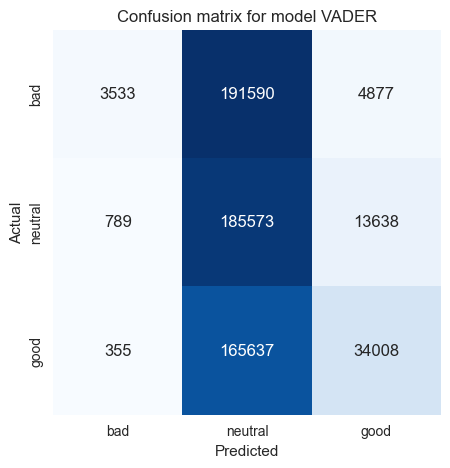

In [162]:
show_model_score(vader_proba, y, 'VADER')

### SVD analysis

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(dataset['text'])

In [ ]:
n_components = 200
U, Sigma, VT = randomized_svd(tfidf_matrix, n_components=n_components, random_state=RANDOM_STATE)
terms_lsa = VT.T @ diag(Sigma)
documents_lsa = U @ diag(Sigma)

In [ ]:
print(f'U shape: {U.shape}')
print(f'Sigma {Sigma.shape}')
print(f'V transposed {VT.shape}')

U shape: (600000, 200)
Sigma (200,)
V transposed (200, 294420)


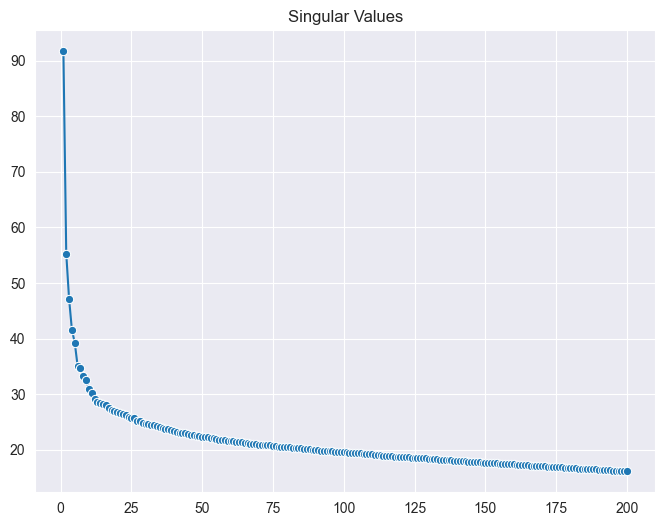

In [ ]:
plot_singular_values(Sigma)

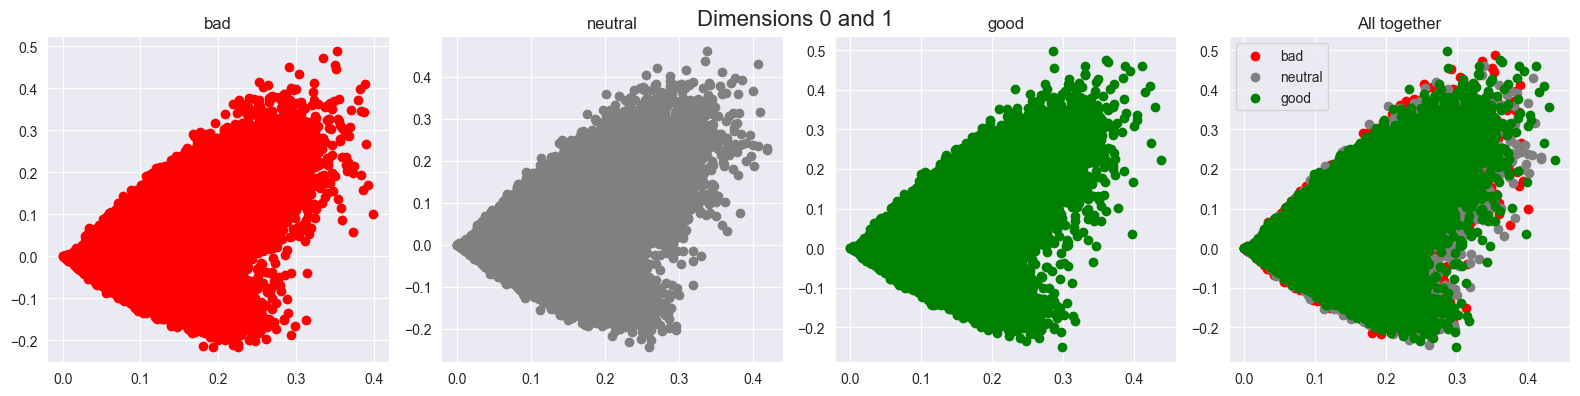

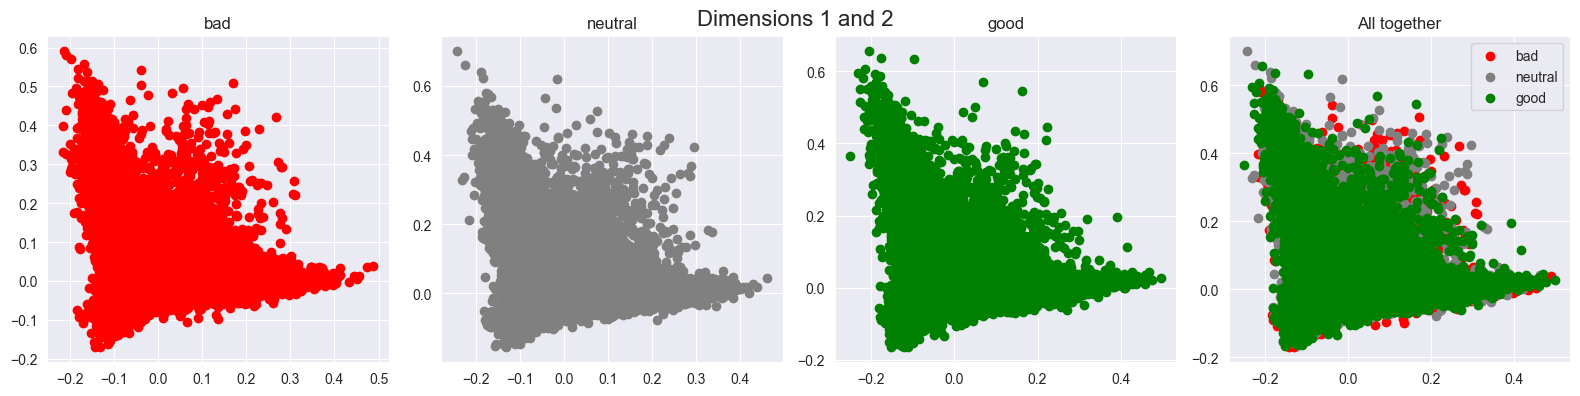

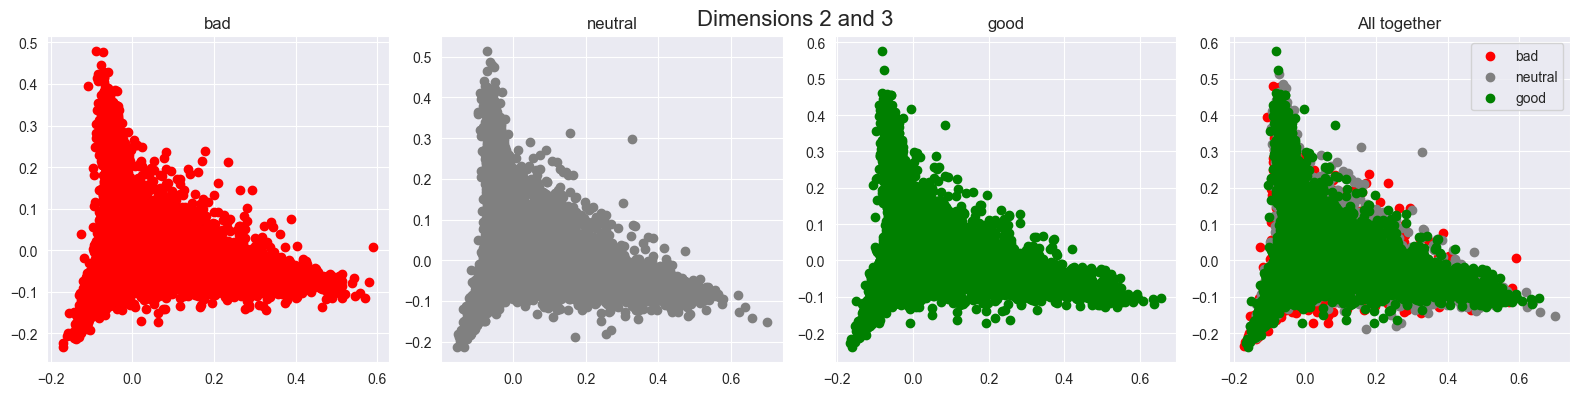

In [ ]:
categories = dataset['sentiment'].values

# Define a color mapping for categories
color_mapping = {
    0: 'red',
    1: 'gray',
    2: 'green',
}

sentiment_mapping = {
    0: 'bad',
    1: 'neutral',
    2: 'good',
}

# Create a scatter plot for each category
for i in range(3):
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    for j, (category, color) in enumerate(color_mapping.items()):
        x = documents_lsa[categories == category, i]
        y = documents_lsa[categories == category, i + 1]

        ax = axes[j]
        ax.scatter(x, y, c=color, label='Scatter 1')
        ax.set_title(sentiment_mapping[category])
        # Adjust layout to prevent overlap
        plt.tight_layout()

    for j, (category, color) in enumerate(color_mapping.items()):
        x = documents_lsa[categories == category, i]
        y = documents_lsa[categories == category, i + 1]

        scatter = axes[3].scatter(documents_lsa[categories == category, i],
                                  documents_lsa[categories == category, i + 1],
                                  c=color_mapping[category],
                                  label=f'{sentiment_mapping[category]}')
    axes[3].legend()
    axes[3].set_title("All together")
    # Adjust layout to prevent overlap

    plt.suptitle(f'Dimensions {i} and {i + 1}', fontsize=16)
    # Show the plot
    plt.show()

### SVD for words similarity

In [ ]:
weighted_word_encoding = (np.diag(Sigma) @ VT).T

In [ ]:
def compute_similarity(word, weighted_word_encoding, vocabulary, words_to_index, top_n=5):
    target_word_index = words_to_index[word]
    target_word_vector = weighted_word_encoding[target_word_index].reshape(1, -1)
    cosine_similarities = cosine_similarity(target_word_vector, weighted_word_encoding)[0]
    most_similar_words = np.argsort(cosine_similarities)[::-1][1:top_n]

    print(f"For word: {word}")
    print(f'Top {top_n} most correlated words are')
    for idx in most_similar_words:
        print(f"{vocabulary[idx]}: {cosine_similarities[idx]:.2f}")

In [ ]:
compute_similarity('good',
                   weighted_word_encoding,
                   tfidf_vectorizer.get_feature_names_out(),
                   tfidf_vectorizer.vocabulary_)


For word: good
Top 5 most correlated words are
ogooosd: 0.87
ogoodvo: 0.87
ogggdd: 0.87
oggod: 0.87


## Pastrocchi

In [58]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, EarlyStoppingCallback, TrainingArguments, Trainer
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained('finiteautomata/bertweet-base-sentiment-analysis')
model = AutoModelForSequenceClassification.from_pretrained('finiteautomata/bertweet-base-sentiment-analysis')
                                                             
tokenized_data = tokenizer(dataset['text'].head(20).astype(str).tolist(), truncation=True, padding=True, return_tensors='pt')

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


In [71]:
elems = [{key: value[i].unsqueeze(0) for key, value in tokenized_data.items()} for i in range(len(dataset['text'].head(20)))]
    

In [78]:
[torch.argmax(model(**elem).logits, dim=1).numpy()[0] for elem in elems]

[0, 1, 1, 1, 0, 1, 1, 2, 1, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 2]

In [45]:
predictions = torch.argmax(model(**tokenized_data).logits, dim=1)

In [50]:

model(**tokenized_data).logits

In [54]:
np.argmax(a.detach().numpy(), axis=1)

array([0, 1, 1, 1, 0, 1, 1, 2, 1, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 2],
      dtype=int64)

In [48]:
predictions.numpy()

array([0, 1, 1, 1, 0, 1, 1, 2, 1, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 2],
      dtype=int64)

In [46]:
accuracy_score(predictions, [2]*20)

0.15